In [ ]:
# Find running python kernel
import sys
import os
print(os.getcwd())
sys.executable

In [1]:
# General imports
import time
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from matplotlib import animation, cm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic
%matplotlib inline

## Data

In [2]:
data_file = '../baryons-from-mesons/GaussianProcess/data/mesoninputs.dat'
target_file = '../baryons-from-mesons/GaussianProcess/data/mMass.dat'
test_file = '../baryons-from-mesons/GaussianProcess/data/baryoninputs.dat'
test_target_file = '../baryons-from-mesons/GaussianProcess/data/bMass.dat'
light_mesons_file = '../lightmesons.dat'

data = np.loadtxt(data_file)
target = np.loadtxt(target_file)
test = np.loadtxt(test_file)
test_target = np.loadtxt(test_target_file)

### Light & Heavy Mesons

In [3]:
light_mesons_file = '../lightmesons.dat'
heavy_mesons_file = '../heavymesons.dat'

light_mesons = np.loadtxt(light_mesons_file)
heavy_mesons = np.loadtxt(heavy_mesons_file)

In [4]:
# Identify index from main set to find corresponding masses of light/heavy mesons
def find_index(meson_array):
    return np.where((data==meson_array[:, None]).all(-1))[1]

def make_dataset(meson_array, meson_index):
    X_train = meson_array
    Y_train = target[meson_index]
    return X_train, Y_train

In [5]:
# Light Mesons
meson_index = find_index(light_mesons)
X_train, Y_train = make_dataset(light_mesons, meson_index)
X_train.shape, Y_train.shape

((122, 14), (122,))

In [6]:
# Heavy Mesons
meson_index = find_index(heavy_mesons)
X_test, Y_test = make_dataset(heavy_mesons, meson_index)
X_test.shape, Y_test.shape

((74, 14), (74,))

### Light & Heavy Baryons

In [32]:
light_baryons_file = '../lightbaryons.dat'
heavy_baryons_file = '../heavybaryons.dat'

light_baryons = np.loadtxt(light_baryons_file)
heavy_baryons = np.loadtxt(heavy_baryons_file)

In [ ]:
# Light Baryons
baryon_index = find_index(light_baryons)
make_dataset(light_baryons, baryon_index)

#### Filtering out Baryons

In [ ]:
# np.where((test == (0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0.5, 1, 0)).all(axis=1))

# 7 baryons: p, n, lambda^{0}, sigma^{+}, sigma^{0}, sigma^{-}, delta^{++}
indices = [0, 1, 2, 5, 6, 7, 24]
X_test = test[indices]
Y_test = test_target[indices]

Y_test

#### Filtering out Mesons

In [ ]:
# np.where((data == (0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0)).all(axis=1))

# Mesons found in dataset: a_0, f_0, D_{s1}^{-}, D_{s1}^{+}
indices = [10, 28, 137, 138]
X_test = data[indices]
Y_test = target[indices]

Y_test

## Kernels

Recall the covariance function

$$\mathrm{cov}(\mathbf{x}_i,\mathbf{x}_j) = \kappa(\mathbf{x}_i,\mathbf{x}_j) + N_{i,j} \;, \text{where} \; N_{i,j} = \sigma_y^2 \delta_{i,j}$$

where the squared exponential can be written as

$$
K_{\textrm{SE}}(\mathbf{x}_i,\mathbf{x}_j) =
\sigma_f^2 \exp\left(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)
$$

and the rational quadratic kernel is

$$
K_{\textrm{RQ}}(\mathbf{x}_i,\mathbf{x}_j) =
\sigma_f^2 \exp\left(1 + \frac{1}{2 \alpha}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)^{-\alpha}
$$

The prior's covariance is specified by the kernel function. The prior mean is assumed to be data's mean if `normalize_y=True` is passed, and set to constant and $0$ otherwise. 

Hyperparameters of the kernel are optimized during fitting by maximizing the log-marginal-likelihood, based on the passed optimizer. Optimizer can be started repeatedly by specifying the `n_restarts_optimizer` parameter, as it may have multiple local optima.

Starting from the initial hyperparameter values of the kernel, subsequent runs are conducted from hyperparameter values that have been chosen randomly from the range of allowed values.

The noise level in the targets can be specified by passing it via the parameter `alpha`, either globally as a scalar or per datapoint. This is added to the diagonal of the kernel matrix during fitting. It can also be interpreted as the variance of additional Gaussian measurement noise on the training observations.

The `RBF`/`SE` kernel only has an `l` parameter which corresponds to the `length_scale` parameter. To have a $\sigma_f$ parameter as well, we have to compose the `RBF` kernel with a `ConstantKernel`. `l` can either be a scalar (isotropic variant of the kernel) or a vector with the same number of dimensions as the inputs X (anisotropic variant of the kernel).

The `RationalQuadratic` kernel is parameterized by a length scale parameter $l > 0$ and a scale mixture parameter $\alpha > 0$. Only the isotropic variant where `length_scale` is a scalar is supported by `sklearn`.

## Models

In [7]:
def plotter(ground_truth, prediction, cov):
    # Plot the mean and variances
    fig, ax = plt.subplots(figsize=(10, 8))

    # Set font size
    FONT_MEDIUM = 20
    plt.rc('axes', labelsize=FONT_MEDIUM)    # fontsize of the x and y labelsb

    ax.scatter(ground_truth, prediction)
    ax.errorbar(ground_truth, prediction, yerr=cov, linestyle='None')
    ax.set_ylabel('Predicted mass (MeV, Log Scale)')
    ax.set_xlabel('Measured mass (MeV, Log Scale)')
    plt.show()

### Gaussian Processes

For Gaussian processes, we need to add an additional value to distinguish between different particles that constitute the same vector, ranked in order of their masses. From the paper, we will also be using the squared exponential (SE) and rational quadratic (RQ) kernels.

In [ ]:
# noise = np.arange(0.05, 4.05, 0.05)
noise = 1.4**2
constant_value = np.arange(0.6, 5.6, 0.1)
length_scale = np.arange(0.6, 5.6, 0.1)
# for rq kernel
alpha = np.arange(0.6, 5.6, 0.1)

hyperparams = list(zip(constant_value, length_scale))

# For writing results to file
results_df = pd.DataFrame()

for counter, params in enumerate(hyperparams):
    # Change params indexing as tuple elements are added/removed from hyperparams
    sigma_f = params[0]
    l = params[1]
    print(f'Current hyperparams: \n noise: {noise}, constant_value: {sigma_f}, length_scale: {l}')

    rbf = ConstantKernel(sigma_f) * RBF(length_scale=l)
    # rq = ConstantKernel(1.0) * RationalQuadratic(length_scale=1.0, alpha=1.0)

    # Set GP prior to training data's mean and cov with kernel
    gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise, n_restarts_optimizer=10)

    gpr.fit(X_train, Y_train)
    mean, cov = gpr.predict(X_test, return_std=True)
    
    # Store current iteration data
    print(np.exp(mean), '\n', np.exp(Y_test), '\n', cov, '\n')
    current_results_df = pd.DataFrame({'run': counter, 'measured': np.exp(Y_test), 'predicted': np.exp(mean), 'variance': np.exp(cov),
                            'rmse': mean_absolute_error(Y_test, mean), 'alpha/noise': noise,
                            'initial_length scale': l, 'initial_sigma_f': sigma_f,
                            'trained_length_scale': gpr.kernel_.k2.get_params()['length_scale'],
                            'trained_sigma_f': np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])})
    
    # Draw plots
    plotter(Y_test, mean, cov)
    
    # Join dataframes to save 
    results_df = pd.concat([results_df, current_results_df])
    
# write to file
timestamp = time.strftime("%d_%m_%H_%M_%S")
results_df.round(4).to_csv(f'results_{timestamp}.csv', index=False)

### Neural Networks

In [ ]:
iterations = 1000
nn_predictions = []

for _ in range(iterations):
    regr = MLPRegressor(hidden_layer_sizes=(), max_iter=500, solver='lbfgs').fit(X_train, Y_train)
    predictions.append(regr.predict(X_test))

nn_predictions
# regr.score(X_test, Y_test)

In [21]:
mean_nn = [statistics.mean(k) for k in zip(*nn_predictions)]
std_nn = [statistics.stdev(k) for k in zip(*nn_predictions)]

In [31]:
pd.DataFrame({'measured': np.exp(Y_test), 'predicted': np.exp(mean_nn)})

,measured,predicted
0,1869.65,307.915226
1,1869.65,234.622750
2,1864.83,236.928470
3,2006.85,318.102545
4,2010.26,413.410078
...,...,...
69,10513.40,124.891418
70,10524.00,127.200121
71,10579.40,110.980655
72,10889.90,146.299302


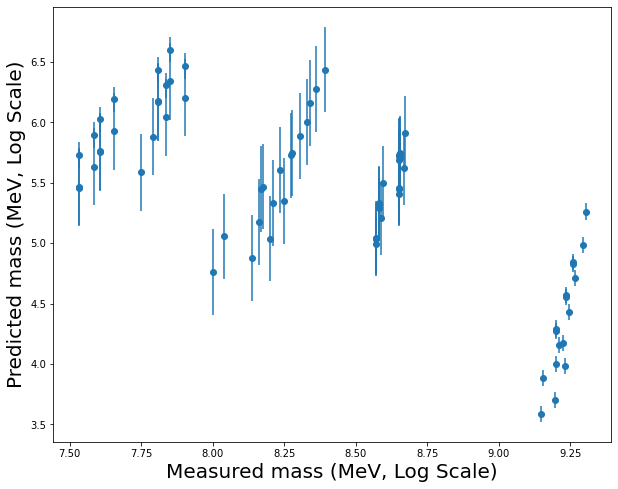

In [23]:
plotter(Y_test, mean_nn, std_nn)

In [19]:
Y_test

array([7.53350653, 7.53350653, 7.53092518, 7.60432161, 7.60601935,
       7.60601935, 7.74846002, 7.79185334, 7.80820114, 7.81010935,
       7.81010935, 7.58494583, 7.58494583, 7.65548534, 7.65548534,
       7.83799231, 7.83799231, 7.85131092, 7.85131092, 7.90407641,
       7.90407641, 8.57155447, 8.57155447, 8.57161319, 8.58010226,
       8.58010226, 8.58010226, 8.65275502, 8.65275502, 8.65278995,
       8.65275502, 8.65275502, 8.65278995, 8.65472657, 8.65472657,
       8.65512738, 8.58800201, 8.67053726, 8.67246039, 8.59700203,
       8.00098645, 8.03815689, 8.13584785, 8.16356218, 8.16774351,
       8.1764394 , 8.19905191, 8.21232345, 8.23566017, 8.24858145,
       8.27343869, 8.27568198, 8.30375242, 8.33009223, 8.34069465,
       8.36030544, 8.39412119, 9.14832666, 9.15485937, 9.19618465,
       9.19956048, 9.20021933, 9.20152261, 9.21266367, 9.22657783,
       9.23332421, 9.23556553, 9.23685084, 9.24524409, 9.26040591,
       9.26141364, 9.26666399, 9.29559103, 9.30500489])

### Gradient Boosting


In [25]:
iterations = 1000
gb_predictions = []

for _ in range(iterations):
    reg = GradientBoostingRegressor().fit(X_train, Y_train)
    predictions.append(reg.predict(X_test))

# plt.scatter(reg.predict(X_test), Y_test)
mean_gb = [statistics.mean(k) for k in zip(*predictions)]
std_gb = [statistics.stdev(k) for k in zip(*predictions)]

In [29]:
pd.DataFrame({'measured': np.exp(Y_test), 'predicted': np.exp(mean_gb)})

,measured,predicted
0,1869.65,283.989998
1,1869.65,359.839780
2,1864.83,371.091095
3,2006.85,882.414233
4,2010.26,879.696705
...,...,...
69,10513.40,1686.920118
70,10524.00,1972.574768
71,10579.40,1735.468934
72,10889.90,1757.122642


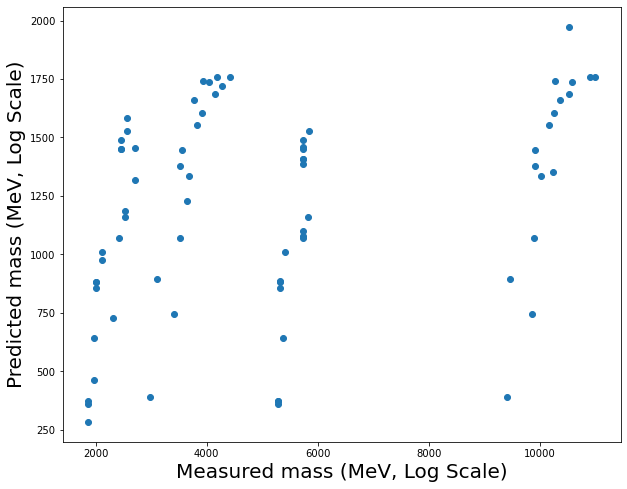

In [30]:
plotter(np.exp(Y_test), np.exp(mean_gb), np.exp(std_gb))